# QSP Notebook - QSP Designer Export Demo

--------------------

In [1]:
# Import QSP Notebook
import os
from copy import copy

import abm
import matplotlib.pyplot as plt

# Also import other packages
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Plotnine (ggplot for Python)
import plotnine as p9
from SALib.analyze import sobol
from SALib.sample import sobol as sobol_sample
from sklearn import metrics
from utilities import project_utilities as utils

--------------------

### Loading QSP Designer Exports

#### Exporting QSP Designer Models

#TODO write introduction and explanation of export process

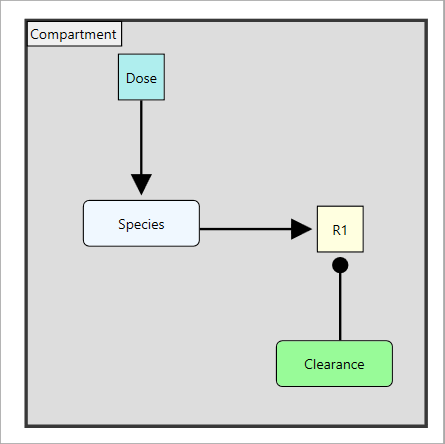

*QSP Notebook export of ./workspaces/one_compartment.qsp*

#### Importing into QSP Notebook

#TODO general structure of exports

We can run the model with no dosing at one time point to check the export worked

In [64]:
model_dir = "./models/qspAppliedBioMathDSL_05_Aug_2024_10.51.32"
model_name = "one_compartment.txt"
dosing_name = "one_compartment_Dosing.csv"

In [65]:
abm.simulate(models=os.path.join(model_dir, model_name), times=["1:1"]).to_pandas()

Total: 2, Running: 0, Succeeded: 2, Failed: 0

,id,t,Clearance,Compartment,Species,Clearance_sim,Compartment_sim_init,Species_sim_init,Species_sim
0,0,1.0,1.0,1.0,0.0,2.777778e-07,0.001,0.0,0.0


#### Loading dosing table exported from QSP Designer

In [66]:
dosing = pd.read_csv(os.path.join(model_dir, dosing_name))
dosing

,ID,route,amounts,durations,times
0,-1,Species_sim_Route,0.0,0.0,0


Currently, the dosing export functionality is not working correctly, new columns and amount needs to be added

In [67]:
dosing["amount_unit"] = 1
dosing["duration_unit"] = 1
dosing["time_unit"] = 1
dosing["amounts"] = 1e-6  # Simulation base unit is Kg, we dose 1 mg
dosing

,ID,route,amounts,durations,times,amount_unit,duration_unit,time_unit
0,-1,Species_sim_Route,0.000001,0.0,0,1,1,1


### Simulating Exported Model
#### Simulate Model

Dosing times are passed via the `times` argument in the `abm.simulate()` function

In [68]:
# Exported model time unit is seconds and we simulate for 24 hours
output_times = list(np.linspace(0.0, 24.0 * 60 * 60, 200))
# We can also use abm.linspace(start, stop, n_points, unit)
output_times = abm.linspace(0, 24 * 60 * 60, 200, "1")

In [69]:
sim_out = abm.simulate(
    models=os.path.join(model_dir, model_name),
    doses=dosing,
    times=output_times,
    outputs=["Species"],
).to_pandas()
sim_out.head()

Total: 2, Running: 0, Succeeded: 2, Failed: 0

,id,t,Species
0,0,0.000000,1.000000
1,0,434.170854,0.887672
2,0,868.341709,0.787016
3,0,1302.512563,0.697205
4,0,1736.683417,0.617514


#### Compare outputs

Load QSP Designer outputs for the same simulation

In [70]:
designer_out = pd.read_csv(
    "./data/outputs/ResultsFolder_05Aug2024_11.49.13/QSPStates.csv",
    names=["id", "t", "Species"],
    header=0,
)
designer_out.head()

,id,t,Species
0,1,0.000000,1.000000
1,1,0.120603,0.886377
2,1,0.241206,0.785659
3,1,0.361809,0.696403
4,1,0.482412,0.617296


In [71]:
# Convert notebook output times to hours
sim_out["t"] = sim_out["t"].div(60 * 60)
# Add labels
designer_out["label"] = "designer"
sim_out["label"] = "notebook"

outputs = pd.concat([sim_out, designer_out])
outputs

,id,t,Species,label
0,0,0.000000,1.000000,notebook
1,0,0.120603,0.887672,notebook
2,0,0.241206,0.787016,notebook
3,0,0.361809,0.697205,notebook
4,0,0.482412,0.617514,notebook
...,...,...,...,...
195,1,23.517588,-0.000007,designer
196,1,23.638191,-0.000007,designer
197,1,23.758794,-0.000006,designer
198,1,23.879397,-0.000006,designer


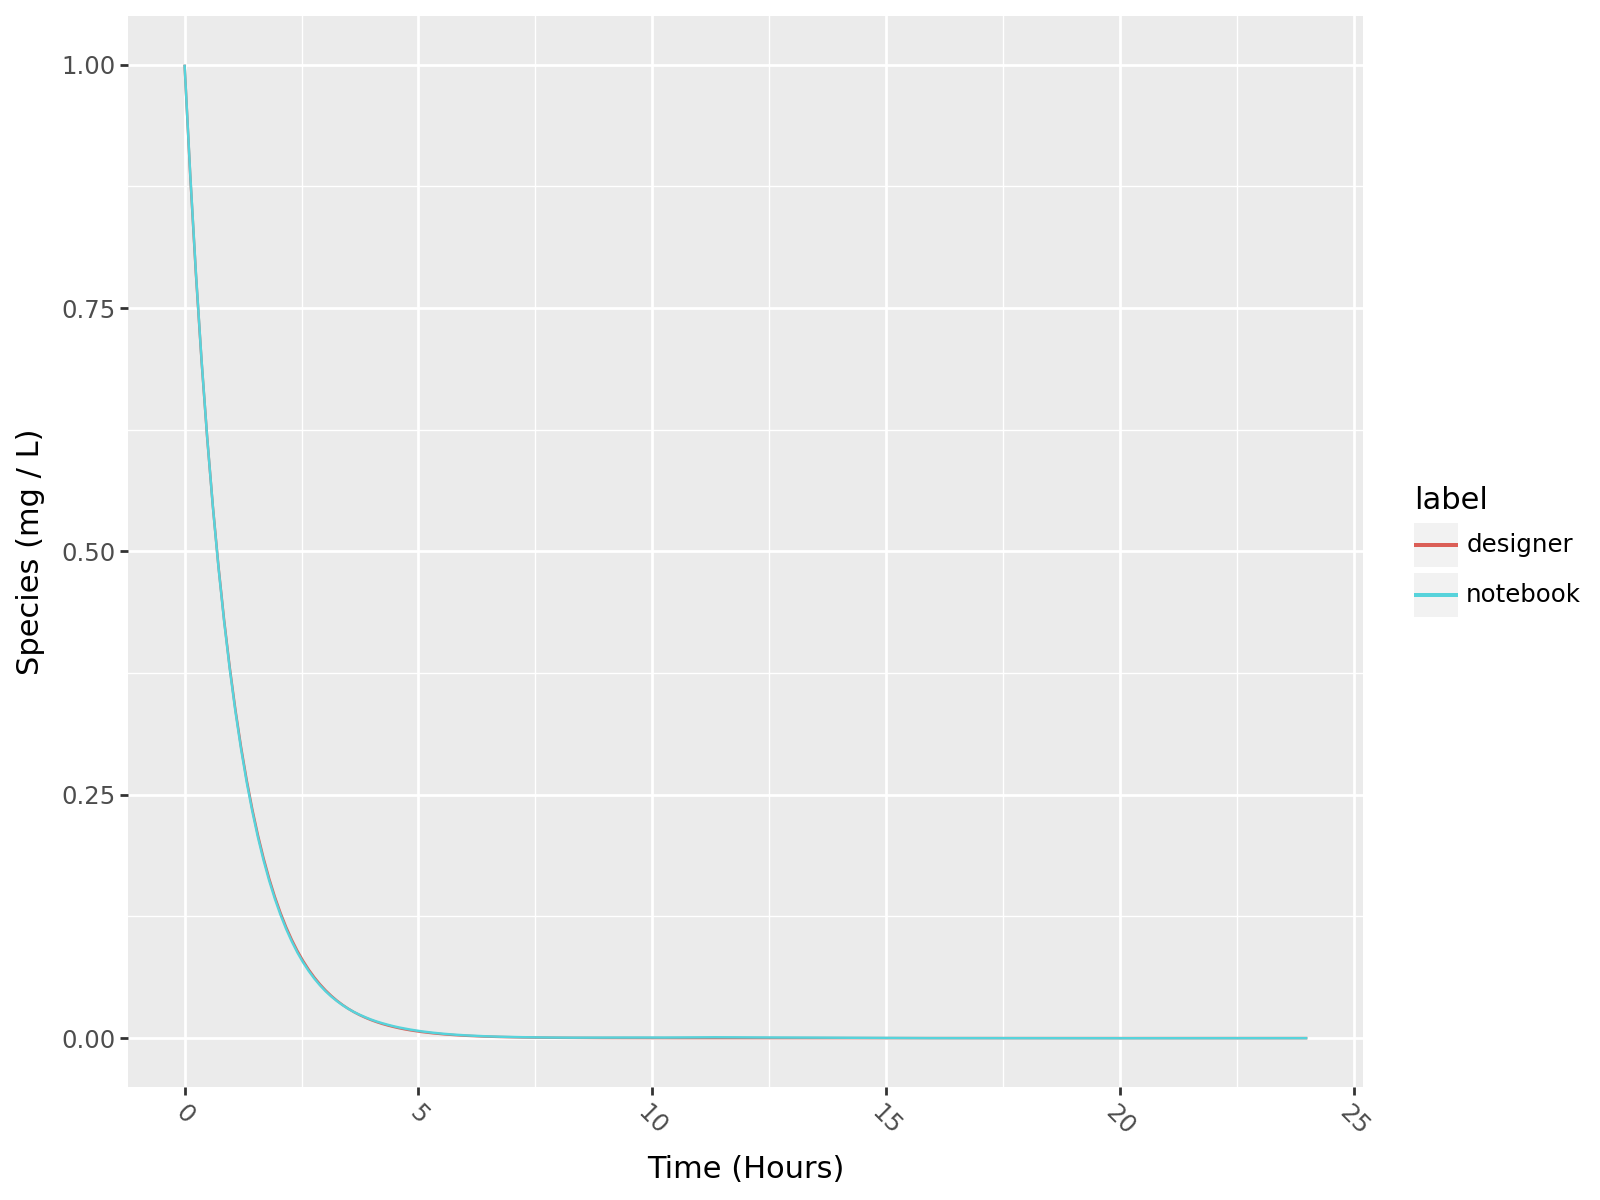

In [72]:
(
    p9.ggplot(outputs, p9.aes("t", "Species", colour="label"))
    + p9.geom_line()
    + p9.labs(x="Time (Hours)", y="Species (mg / L)")
    + p9.theme(figure_size=(8, 6), axis_text_x=p9.element_text(rotation=-45))
)

We can calculate the AUC for our individual using the trapezoidal method in sklearn (We can calculate this by hand easily in this case, from the formula `Cl = Dose/AUC`)

In [448]:
metrics.auc(
    sim_out["t"], sim_out["Species"]
)  # AUC = Dose / Cl = 1, trapezoidal is approximate method, hence small error

1.0020165333688604

/home/jovyan/qsp-designer-demo/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
/home/jovyan/qsp-designer-demo/.venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 150 rows containing missing values.


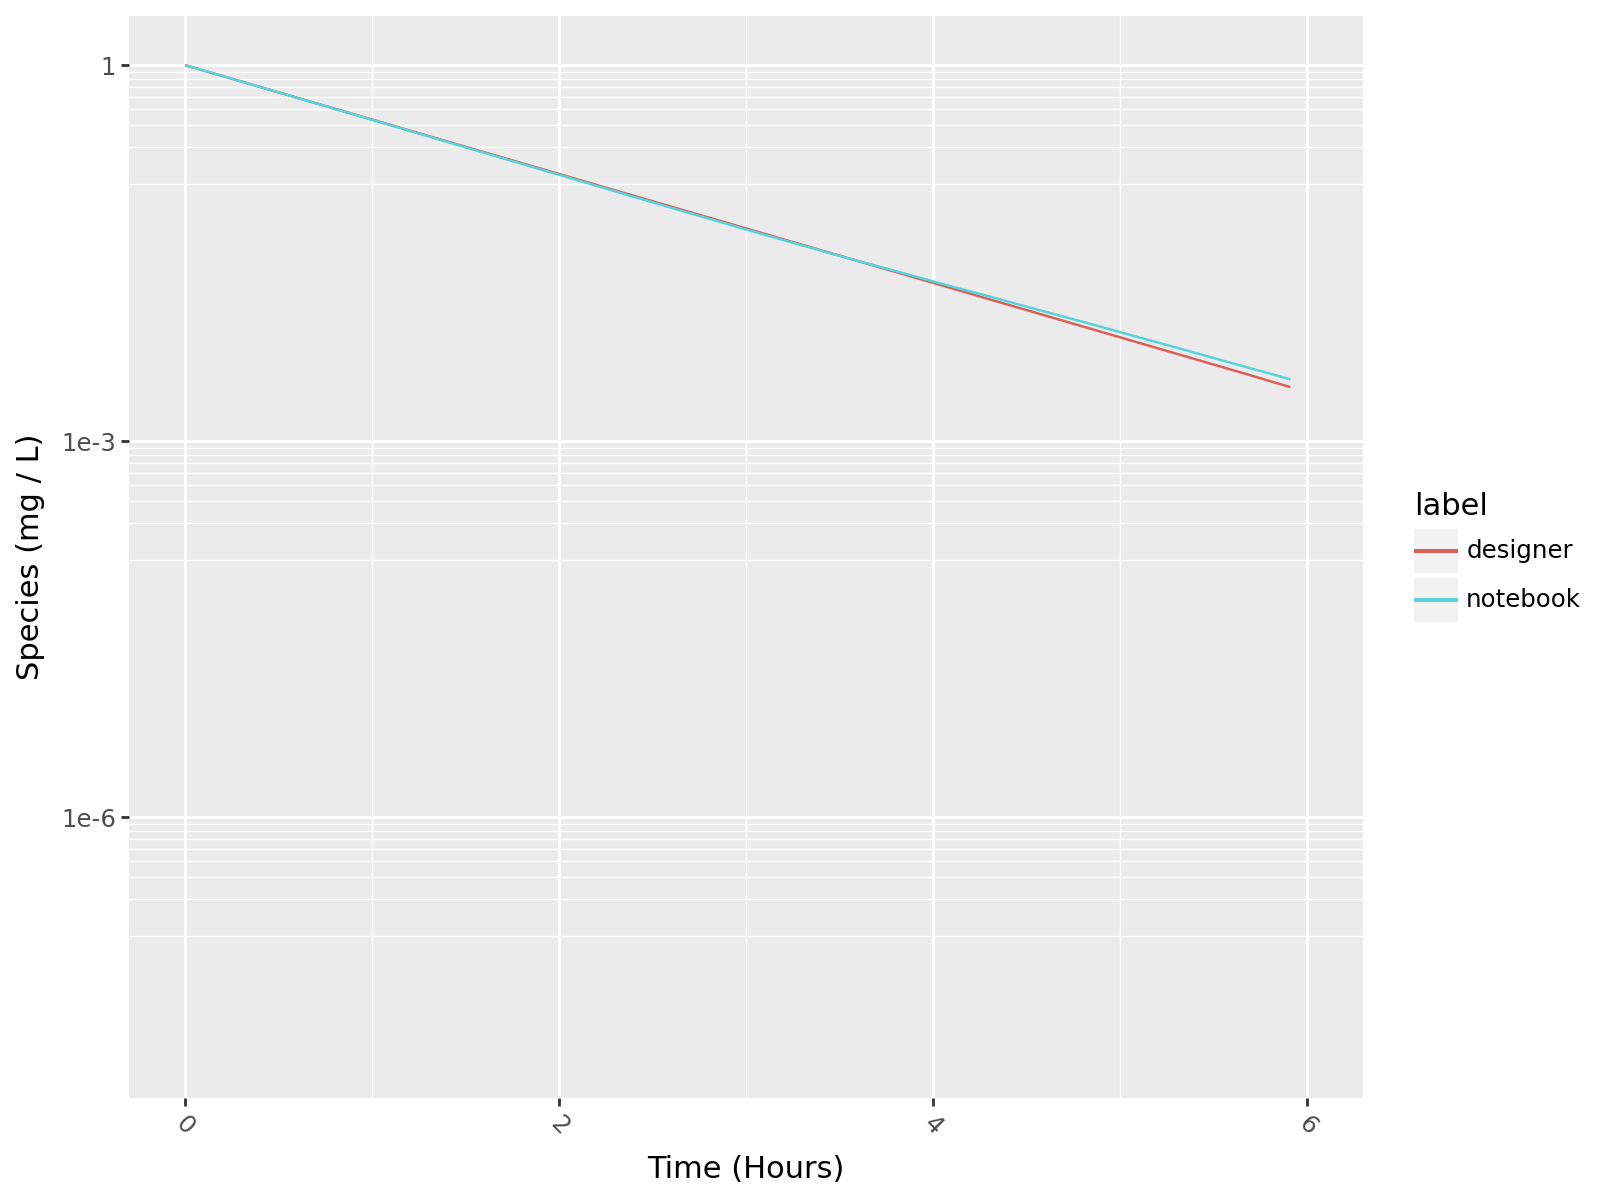

In [77]:
(
    p9.ggplot(outputs, p9.aes("t", "Species", colour="label"))
    + p9.geom_line()
    + p9.labs(x="Time (Hours)", y="Species (mg / L)")
    + p9.theme(figure_size=(8, 6), axis_text_x=p9.element_text(rotation=-45))
    + p9.scale_y_log10()
    + p9.xlim(0, 6)
)

### Simulating Different Regimens

#### Different initial doses

In [78]:
new_dosing = pd.concat([dosing] * 3)
new_dosing["ID"] = ["1", "2", "3"]  # ID maps to simulations table
new_dosing["amounts"] = 1.0e-6 * np.array([1.0, 2.0, 3.0])  # 1, 2 and 3 mg doses
new_dosing

,ID,route,amounts,durations,times,amount_unit,duration_unit,time_unit
0,1,Species_sim_Route,0.000001,0.0,0,1,1,1
0,2,Species_sim_Route,0.000002,0.0,0,1,1,1
0,3,Species_sim_Route,0.000003,0.0,0,1,1,1


In [79]:
escalating_out = abm.simulate(
    simulations=pd.DataFrame({"ID": ["1", "2", "3"]}),  # Simulation table
    models=os.path.join(model_dir, model_name),
    doses=new_dosing,
    times=output_times,
    outputs=["Species"],
).to_pandas()
escalating_out["t"] = escalating_out["t"].div(60 * 60)

Total: 4, Running: 0, Succeeded: 4, Failed: 0

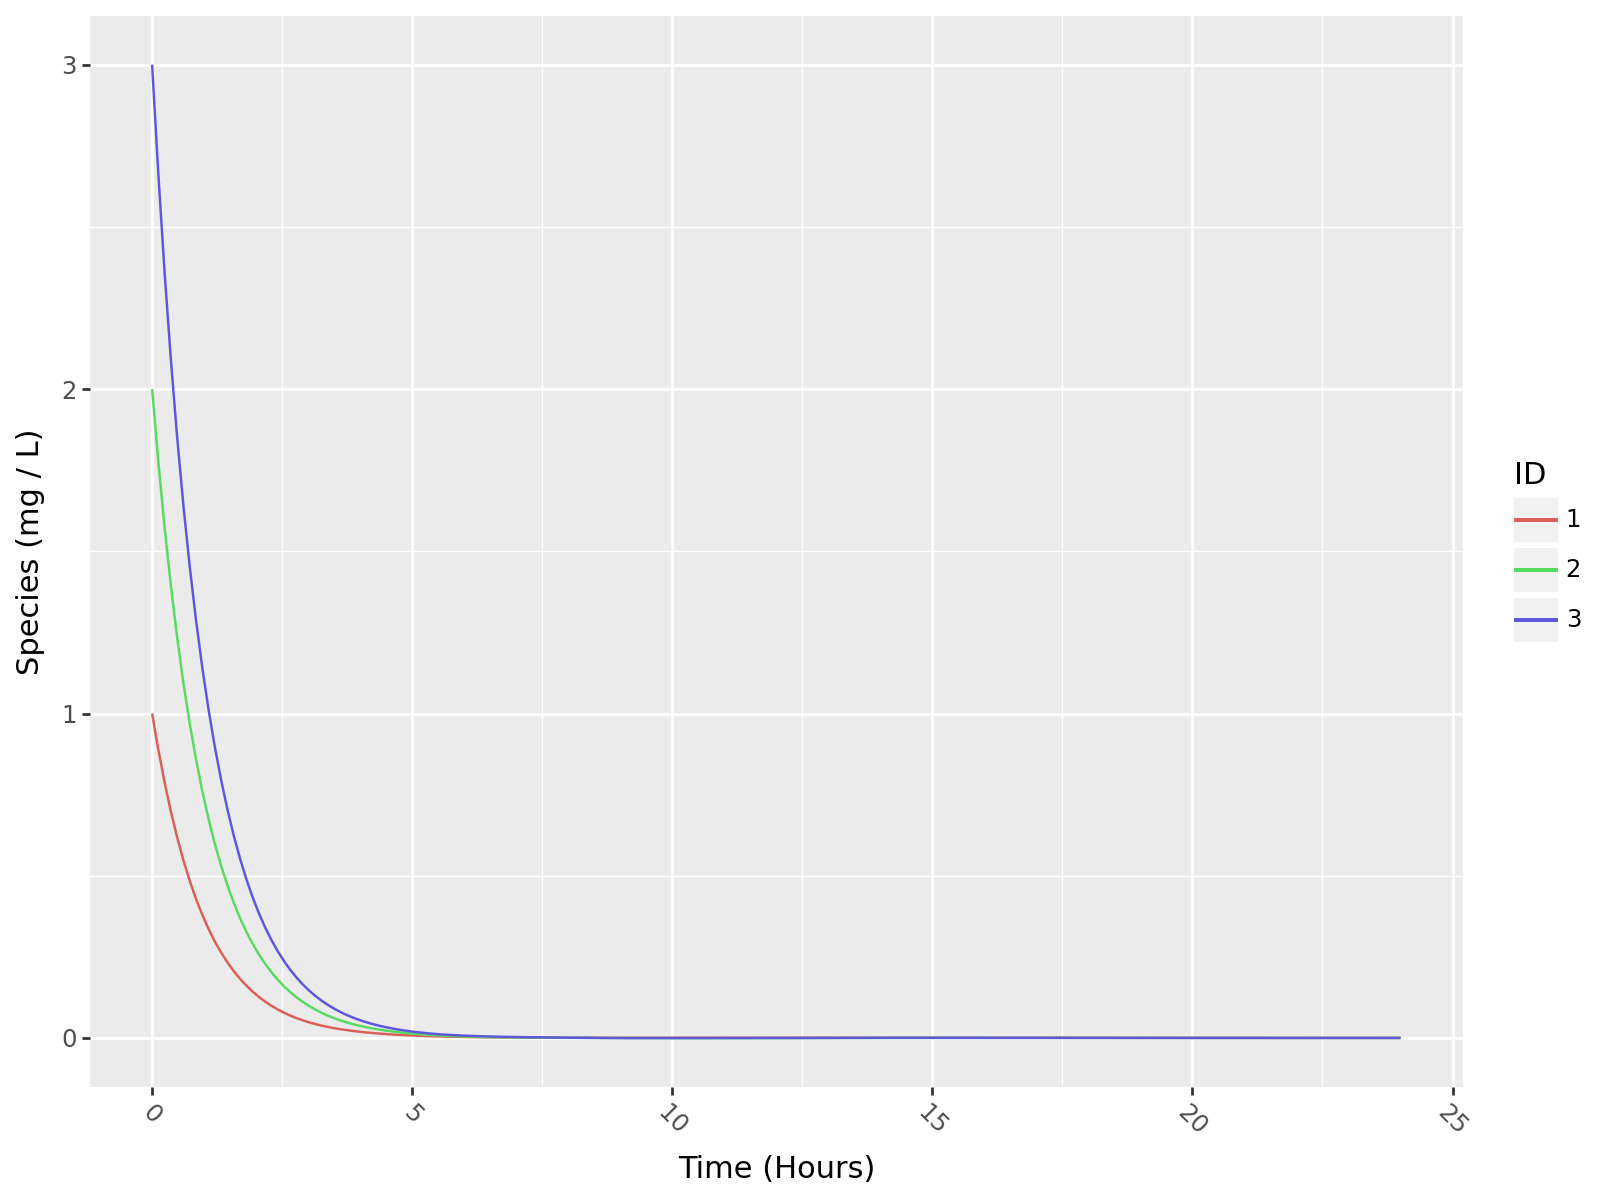

In [80]:
(
    p9.ggplot(escalating_out, p9.aes("t", "Species", colour="ID"))
    + p9.geom_line()
    + p9.labs(x="Time (Hours)", y="Species (mg / L)")
    + p9.theme(figure_size=(8, 6), axis_text_x=p9.element_text(rotation=-45))
)

In [124]:
aucs = (
    escalating_out.groupby(["ID"])
    .apply(lambda x: metrics.auc(x["t"], x["Species"]), include_groups=False)
    .reset_index(name="AUC")
)
aucs

,ID,AUC
0,1,1.002017
1,2,2.000513
2,3,2.996417


#### Multiple doses

In [15]:
dosing_multiple = copy(dosing)
dosing_multiple["times"] = [
    [i * 60 * 60 for i in [0, 6, 12]]
]  # Dosing at 0, 6 and 12 hours
dosing_multiple

,ID,route,amounts,durations,times,amount_unit,duration_unit,time_unit
0,-1,Species_sim_Route,0.000001,0.0,"[0, 21600, 43200]",1,1,1


In [16]:
multiple_out = abm.simulate(
    models=os.path.join(model_dir, model_name),
    doses=dosing_multiple,
    times=abm.linspace(0, 24 * 60 * 60, 25 * 25),
    outputs=["Species"],
).to_pandas()
multiple_out["t"] = multiple_out["t"].div(60 * 60)

Total: 2, Running: 0, Succeeded: 2, Failed: 0

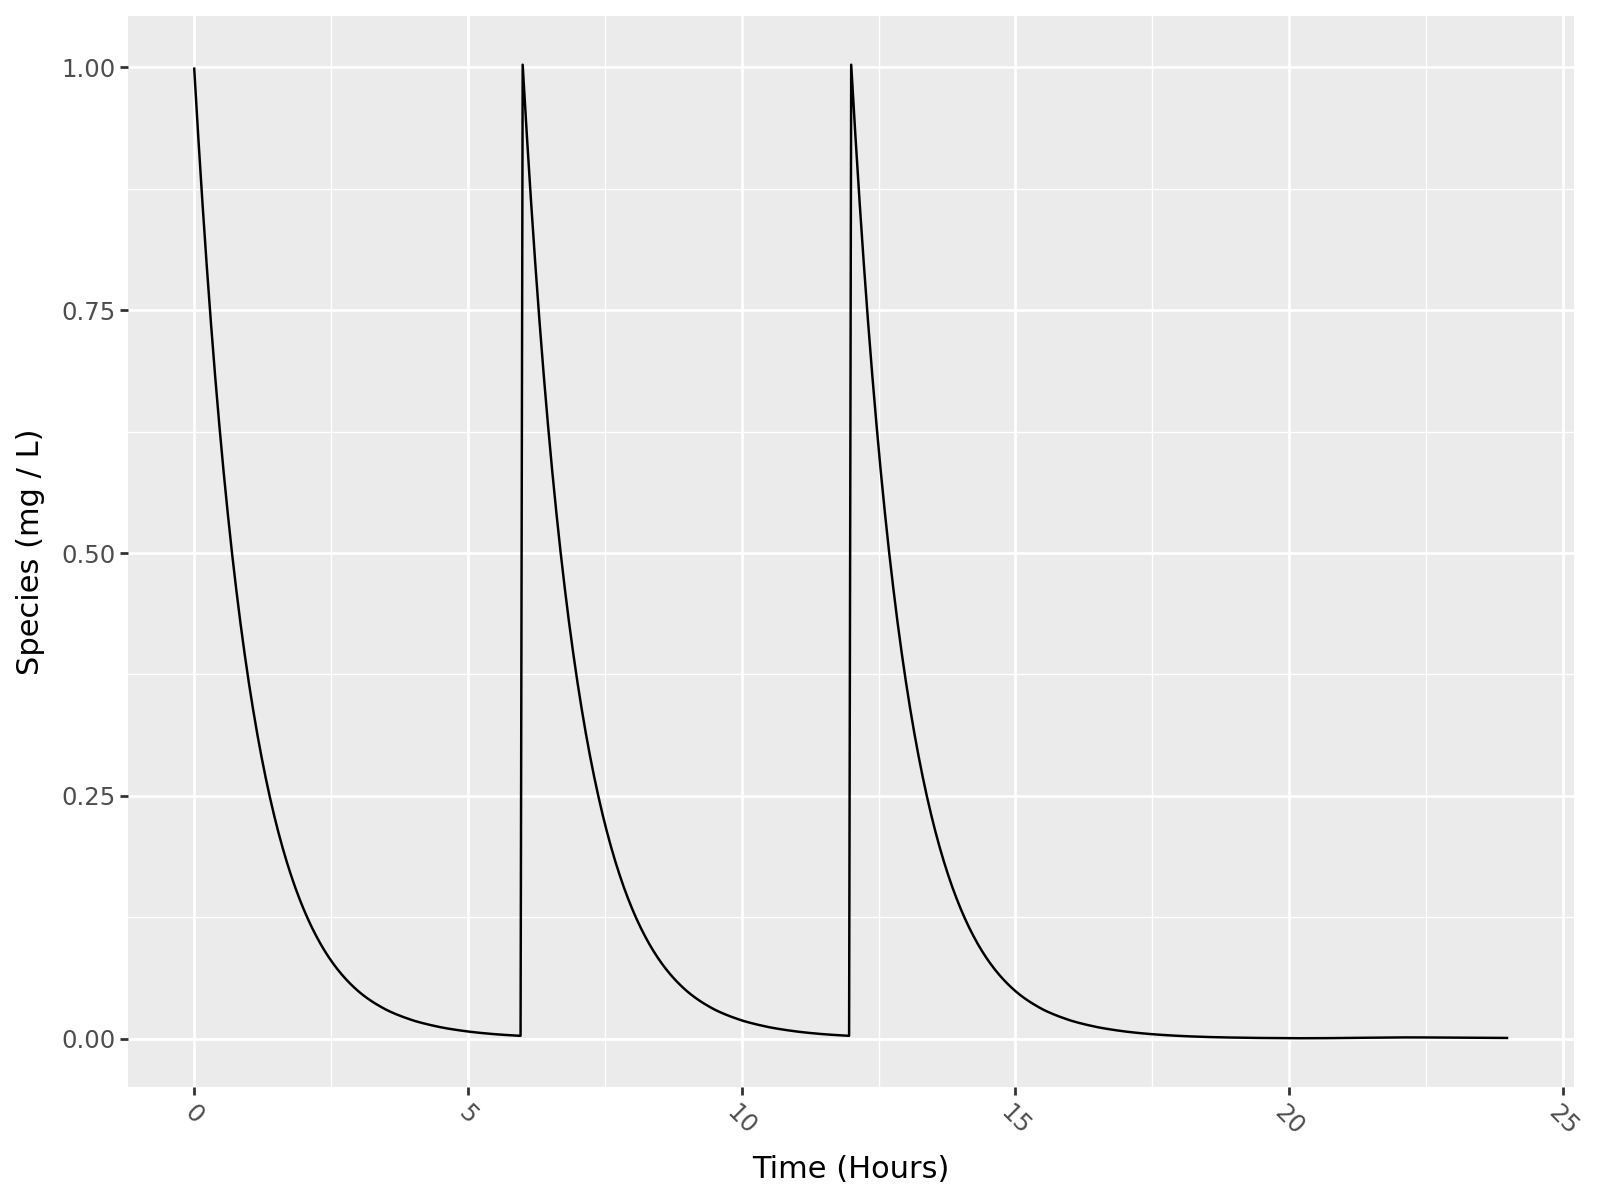

In [17]:
(
    p9.ggplot(multiple_out, p9.aes("t", "Species"))
    + p9.geom_line()
    + p9.labs(x="Time (Hours)", y="Species (mg / L)")
    + p9.theme(figure_size=(8, 6), axis_text_x=p9.element_text(rotation=-45))
)

### Working with VPops

A typical virtual population (VPop) input for QSP Designer uses one row per individual in the population

In [18]:
N_indivs = 100
np.random.seed(123)
vpop = pd.DataFrame(
    {
        "ID": pd.Series(range(1, N_indivs + 1)),
        "Compartment": pd.Series(np.random.uniform(0.8, 1.2, N_indivs)),
        "Clearance": pd.Series(np.random.uniform(0.5, 2, N_indivs)),
    }
)
vpop.to_csv("./data/vpop.csv", index=False)
vpop

,ID,Compartment,Clearance
0,1,1.078588,1.269692
1,2,0.914456,1.499937
2,3,0.890741,0.658863
3,4,1.020526,0.696342
4,5,1.087788,0.982971
...,...,...,...
95,96,1.076681,1.453851
96,97,0.860451,0.548297
97,98,0.959551,1.617171
98,99,0.896342,1.209370


#### Conversion to base units

#TODO Tidy up this section

Before exporting, QSP Designer converts all model parameters to base units. This means that the parameter values in the Designer model are not the same as those used in Notebook. For example, our dose in Designer is 1 mg but our dose input in earlier simulations was 1E-6 as base unit for weight is 1 kg.

In the VPop we created above, our parameters are the same as those shown on-screen in Designer and are converted at run time. In order to use this VPop with Notebook we need to convert it to base units. Designer can do this for you from the Generate Scripts interface (File -> Generate -> Model Script):

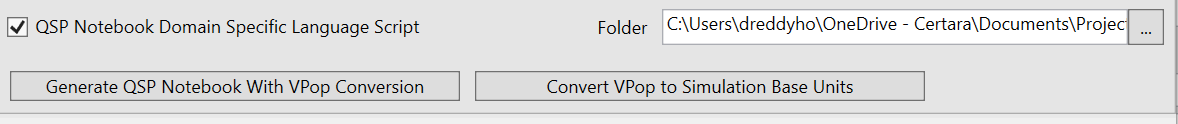

We have the option to either generate our export using the VPop, which will create a new dosing table, or to simply convert to base units.

In [2]:
model_dir = "./models/qspAppliedBioMathDSL_06_Aug_2024_13.31.34"
model_name = "one_compartment.txt"
dosing_name = "one_compartment_Dosing.csv"
vpop_name = "one_compartment_VPop.csv"

In [3]:
vpop_converted = pd.read_csv(os.path.join(model_dir, vpop_name))
vpop_converted

,ID,Clearance_sim,Compartment_sim_init
0,1,3.526923e-07,0.001079
1,2,4.166491e-07,0.000914
2,3,1.830174e-07,0.000891
3,4,1.934285e-07,0.001021
4,5,2.730475e-07,0.001088
...,...,...,...
95,96,4.038474e-07,0.001077
96,97,1.523047e-07,0.000860
97,98,4.492142e-07,0.000960
98,99,3.359360e-07,0.000896


In [127]:
parameters = utils.vpop_to_param(os.path.join(model_dir, vpop_name))
parameters

,ID,parameter,value,unit
0,1,Clearance_sim,3.526923e-07,1
1,1,Compartment_sim_init,1.078588e-03,1
2,2,Clearance_sim,4.166491e-07,1
3,2,Compartment_sim_init,9.144557e-04,1
4,3,Clearance_sim,1.830174e-07,1
...,...,...,...,...
195,98,Clearance_sim,4.492142e-07,1
196,99,Compartment_sim_init,8.963424e-04,1
197,99,Clearance_sim,3.359360e-07,1
198,100,Clearance_sim,1.896199e-07,1


In [128]:
doses = pd.read_csv(os.path.join(model_dir, dosing_name))
doses

,ID,route,amounts,durations,times,amount_unit,duration_unit,time_unit
0,1,Species_sim_Route,0.000001,0,0,1,1,1
1,2,Species_sim_Route,0.000001,0,0,1,1,1
2,3,Species_sim_Route,0.000001,0,0,1,1,1
3,4,Species_sim_Route,0.000001,0,0,1,1,1
4,5,Species_sim_Route,0.000001,0,0,1,1,1
...,...,...,...,...,...,...,...,...
95,96,Species_sim_Route,0.000001,0,0,1,1,1
96,97,Species_sim_Route,0.000001,0,0,1,1,1
97,98,Species_sim_Route,0.000001,0,0,1,1,1
98,99,Species_sim_Route,0.000001,0,0,1,1,1


In [129]:
simulations = pd.DataFrame(vpop_converted["ID"])
simulations

,ID
0,1
1,2
2,3
3,4
4,5
...,...
95,96
96,97
97,98
98,99


In [130]:
vpop_out = abm.simulate(
    models=os.path.join(model_dir, model_name),
    simulations=simulations,
    doses=doses,
    parameters=parameters,
    times=output_times,
).to_pandas()
vpop_out["t"] = vpop_out["t"].div(60 * 60)
vpop_out["ID"] = vpop_out["ID"].astype(str)

Total: 101, Running: 0, Succeeded: 101, Failed: 0

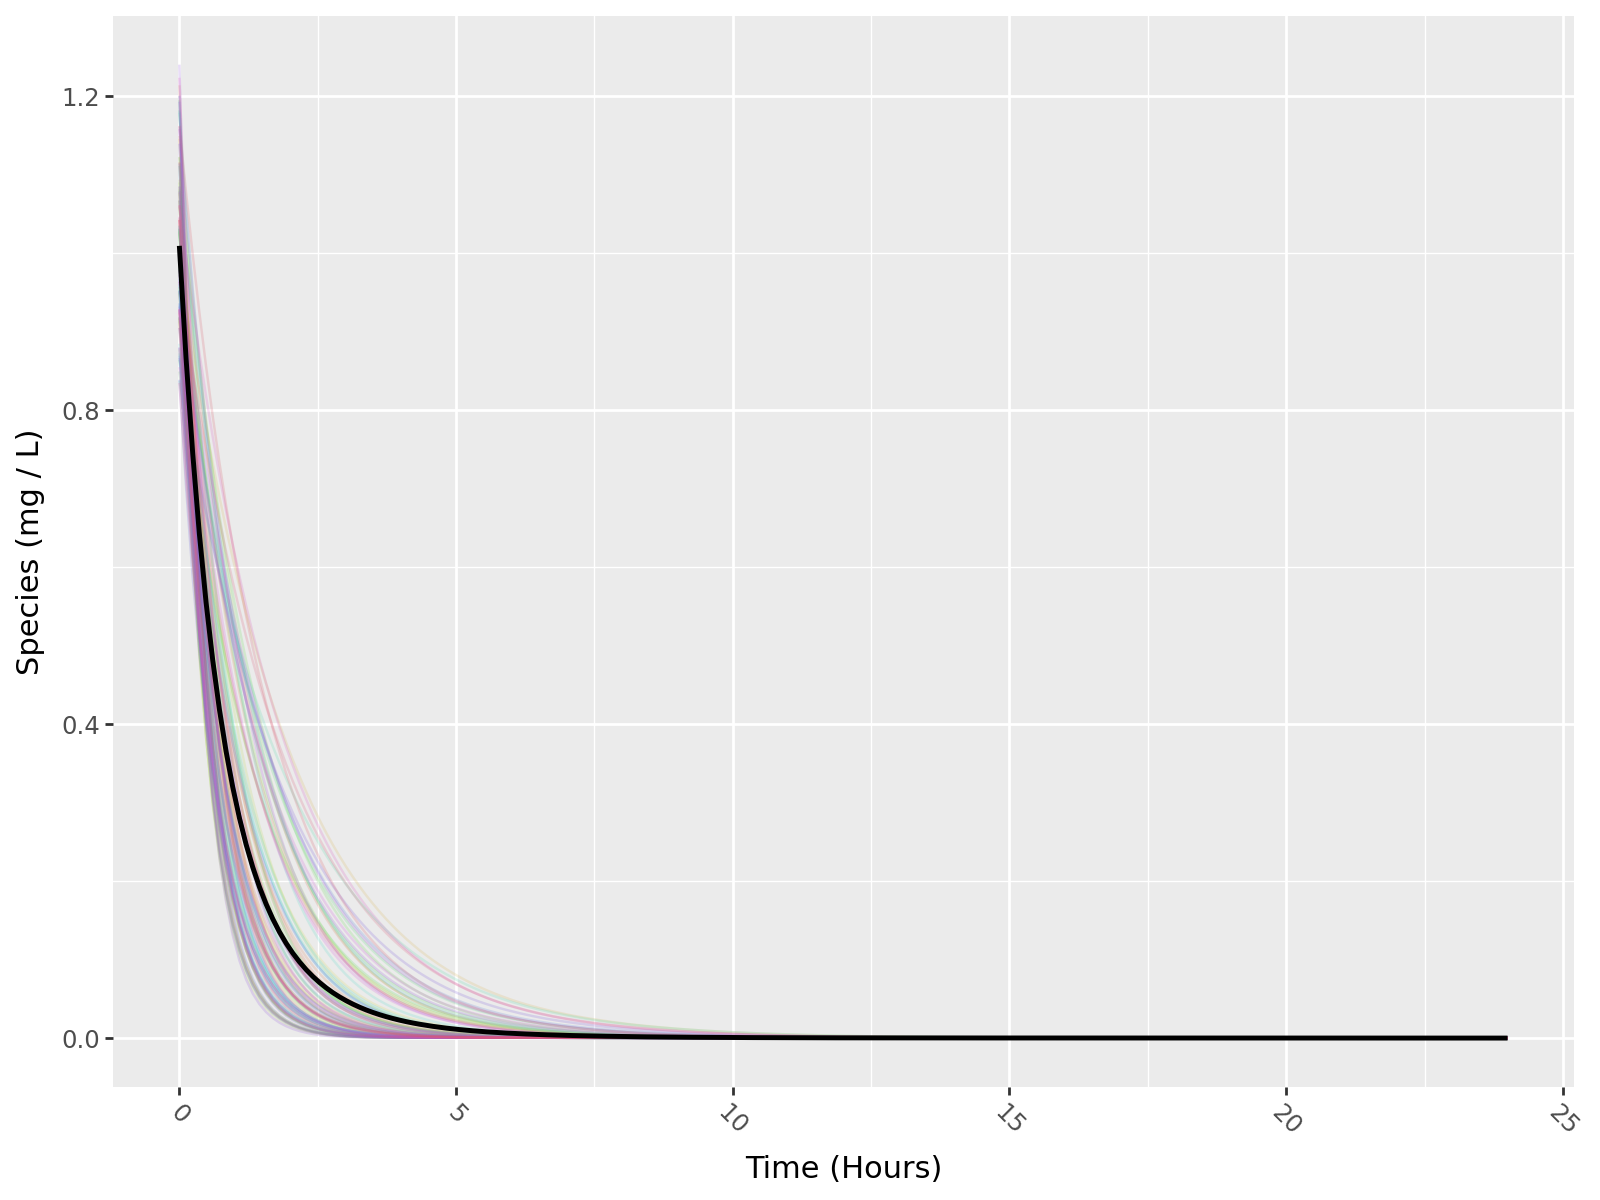

In [140]:
(
    p9.ggplot(vpop_out, p9.aes("t", "Species", colour="ID"))
    + p9.geom_line(alpha=0.2)
    # Get mean concentration at each timepoint
    + p9.geom_line(
        data=vpop_out.groupby(vpop_out["t"])["Species"].mean().reset_index(),
        mapping=p9.aes(x="t", y="Species"),
        inherit_aes=False,
        size=1,
    )
    + p9.labs(x="Time (Hours)", y="Species (mg / L)")
    + p9.theme(figure_size=(8, 6), axis_text_x=p9.element_text(rotation=-45))
    + p9.guides(colour=False)
)

In [139]:
vpop_aucs = (
    vpop_out.groupby(["ID"])
    .apply(lambda x: metrics.auc(x["t"], x["Species"]), include_groups=False)
    .reset_index(name="AUC")
    .sort_values("AUC")
)
vpop_aucs

,ID,AUC
13,20,0.507304
29,35,0.509356
19,26,0.509548
88,89,0.530190
38,43,0.531967
...,...,...
43,48,1.745639
97,97,1.827566
95,95,1.839888
86,87,1.958664


### Sensitivity Analysis

#### Sobol Method using SALib

In [4]:
cl_mean = vpop_converted["Clearance_sim"].mean()
vol_mean = vpop_converted["Compartment_sim_init"].mean()
problem = {
    "num_vars": 2,
    "names": ["Clearance_sim", "Compartment_sim_init"],
    "bounds": [[1e-1 * cl_mean, 1e1 * cl_mean], [1e-1 * vol_mean, 1e1 * vol_mean]],
}

In [8]:
param_vals = sobol_sample.sample(problem, 1024, calc_second_order=False)
N_sims = len(param_vals)

In [14]:
N_sims

4096

In [187]:
vpop = pd.DataFrame(
    {
        "ID": np.array(range(1, N_sims + 1)),
        problem["names"][0]: pd.Series(param_vals[0:, :1].reshape(-1)),
        problem["names"][1]: pd.Series(param_vals[0:, 1:].reshape(-1)),
    }
)
parameters = utils.df_to_param(vpop)
parameters

,ID,parameter,value,unit
0,1,Clearance_sim,4.920756e-07,1
1,1,Compartment_sim_init,6.477239e-03,1
2,2,Compartment_sim_init,6.477239e-03,1
3,2,Clearance_sim,4.548530e-07,1
4,3,Compartment_sim_init,8.757444e-03,1
...,...,...,...,...
12283,6142,Clearance_sim,4.898240e-07,1
12284,6143,Compartment_sim_init,4.615214e-03,1
12285,6143,Clearance_sim,3.049808e-06,1
12286,6144,Clearance_sim,3.049808e-06,1


In [189]:
sens_doses = dose1.loc[dose1.index.repeat(N_sims)]
sens_doses["ID"] = np.array(range(1, N_sims + 1))
sens_doses

,ID,route,amounts,durations,times,amount_unit,duration_unit,time_unit
0,1,Species_sim_Route,0.000001,0,0,1,1,1
0,2,Species_sim_Route,0.000001,0,0,1,1,1
0,3,Species_sim_Route,0.000001,0,0,1,1,1
0,4,Species_sim_Route,0.000001,0,0,1,1,1
0,5,Species_sim_Route,0.000001,0,0,1,1,1
...,...,...,...,...,...,...,...,...
0,6140,Species_sim_Route,0.000001,0,0,1,1,1
0,6141,Species_sim_Route,0.000001,0,0,1,1,1
0,6142,Species_sim_Route,0.000001,0,0,1,1,1
0,6143,Species_sim_Route,0.000001,0,0,1,1,1


In [190]:
sens_out = abm.simulate(
    models=os.path.join(model_dir, model_name),
    simulations=pd.DataFrame(sens_doses["ID"]),
    doses=sens_doses,
    parameters=parameters,
    times=output_times,
).to_pandas()
sens_out["t"] = sens_out["t"].div(60 * 60)
# sens_out["ID"] = sens_out["ID"].astype(str)

Total: 4752, Running: 0, Succeeded: 4752, Failed: 0

In [191]:
sens_out

,ID,id,t,Clearance,Compartment,Species,Clearance_sim,Compartment_sim_init,Species_sim_init,Species_sim
0,1,0,0.000000,1.771472,6.477239,1.543868e-01,4.920756e-07,0.006477,0.0,1.000000e-06
1,1,0,0.120603,1.771472,6.477239,1.494410e-01,4.920756e-07,0.006477,0.0,9.679650e-07
2,1,0,0.241206,1.771472,6.477239,1.446675e-01,4.920756e-07,0.006477,0.0,9.370459e-07
3,1,0,0.361809,1.771472,6.477239,1.400322e-01,4.920756e-07,0.006477,0.0,9.070220e-07
4,1,0,0.482412,1.771472,6.477239,1.355090e-01,4.920756e-07,0.006477,0.0,8.777242e-07
...,...,...,...,...,...,...,...,...,...,...
1228795,6144,6143,23.517588,10.979307,9.425235,2.642758e-07,3.049808e-06,0.009425,0.0,2.490861e-12
1228796,6144,6143,23.638191,10.979307,9.425235,3.656718e-07,3.049808e-06,0.009425,0.0,3.446543e-12
1228797,6144,6143,23.758794,10.979307,9.425235,4.555498e-07,3.049808e-06,0.009425,0.0,4.293664e-12
1228798,6144,6143,23.879397,10.979307,9.425235,5.334536e-07,3.049808e-06,0.009425,0.0,5.027926e-12


In [195]:
sens_aucs = (
    sens_out.groupby(["ID"])
    .apply(lambda x: metrics.auc(x["t"], x["Species"]), include_groups=False)
    .reset_index(name="AUC")
)

In [286]:
Si = sobol.analyze(problem, sens_aucs["AUC"].values)

In [204]:
Si["S1"]

array([0.88853944, 0.00325439])

In [205]:
Si["ST"]

array([0.95758028, 0.06217078])

In [429]:
df = pd.DataFrame({"id": [1, 1, 2, 2], "y": [0, 1, 2, 3]})
df

,id,y
0,1,0
1,1,1
2,2,2
3,2,3


In [442]:
ys = df.groupby("id")["y"].apply(np.array)
out = np.array([ys.iloc[i] for i, _ in enumerate(ys)])

In [447]:
out.shape, ys.to_numpy().shape

((2, 2), (2,))

In [449]:
ys = sens_out.groupby("ID")["Species"].apply(np.array)
concs = np.array([ys.iloc[i] for i, _ in enumerate(ys)])

In [450]:
sobol_indices = [sobol.analyze(problem, conc) for conc in concs.T]

/home/jovyan/qsp-designer-demo/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


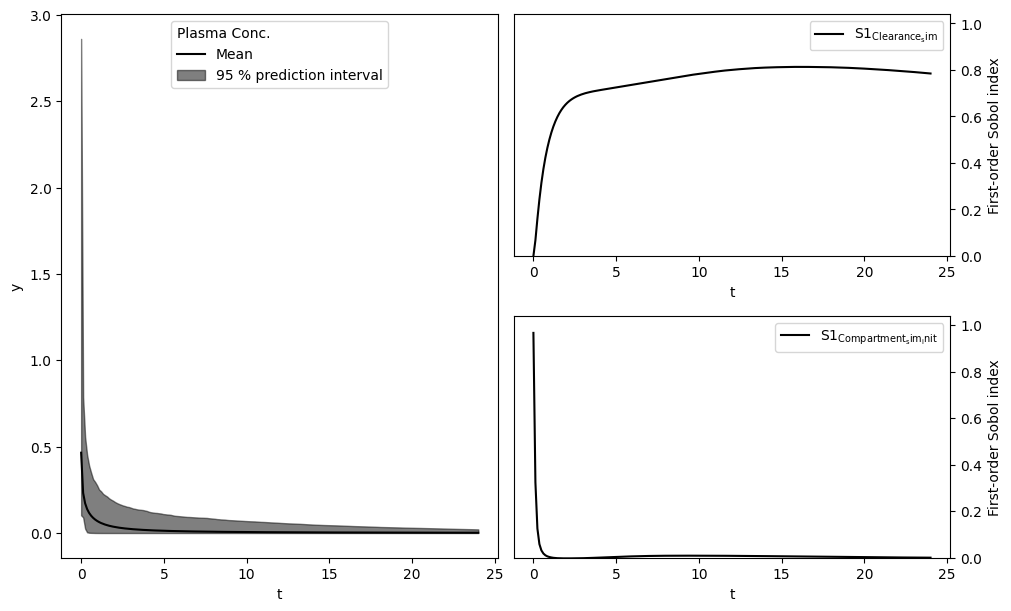

In [451]:
S1s = np.array([s["S1"] for s in sobol_indices])
t = sens_out["t"].unique()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

for i, ax in enumerate([ax1, ax2]):
    ax.plot(
        t,
        S1s[:, i],
        label=r"S1$_\mathregular{{{}}}$".format(problem["names"][i]),
        color="black",
    )
    ax.set_xlabel("t")
    ax.set_ylabel("First-order Sobol index")

    ax.set_ylim(0, 1.04)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.legend(loc="upper right")

ax0.plot(t, np.mean(concs, axis=0), label="Mean", color="black")

# in percent
prediction_interval = 95

ax0.fill_between(
    t,
    np.percentile(concs, 50 - prediction_interval / 2.0, axis=0),
    np.percentile(concs, 50 + prediction_interval / 2.0, axis=0),
    alpha=0.5,
    color="black",
    label=f"{prediction_interval} % prediction interval",
)

ax0.set_xlabel("t")
ax0.set_ylabel("y")
ax0.legend(title="Plasma Conc.", loc="upper center")._legend_box.align = "left"

plt.show()

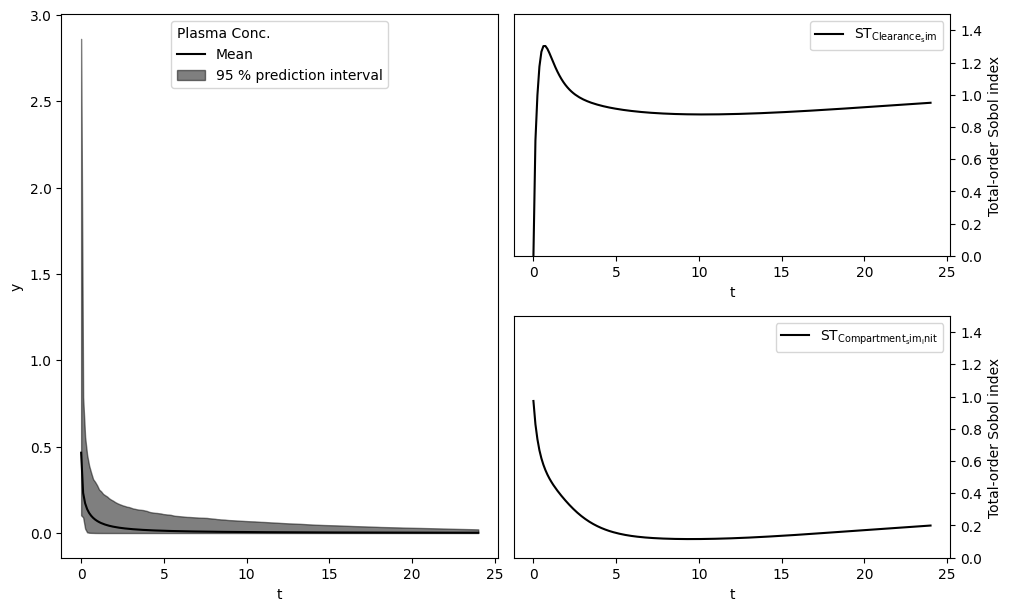

In [483]:
STs = np.array([s["ST"] for s in sobol_indices])
t = sens_out["t"].unique()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

for i, ax in enumerate([ax1, ax2]):
    ax.plot(
        t,
        STs[:, i],
        label=r"ST$_\mathregular{{{}}}$".format(problem["names"][i]),
        color="black",
    )
    ax.set_xlabel("t")
    ax.set_ylabel("Total-order Sobol index")

    ax.set_ylim(0, 1.5)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.legend(loc="upper right")

ax0.plot(t, np.mean(concs, axis=0), label="Mean", color="black")

# in percent
prediction_interval = 95

ax0.fill_between(
    t,
    np.percentile(concs, 50 - prediction_interval / 2.0, axis=0),
    np.percentile(concs, 50 + prediction_interval / 2.0, axis=0),
    alpha=0.5,
    color="black",
    label=f"{prediction_interval} % prediction interval",
)

ax0.set_xlabel("t")
ax0.set_ylabel("y")
ax0.legend(title="Plasma Conc.", loc="upper center")._legend_box.align = "left"

plt.show()